# Predicting Citation Count with Machine Learning <a class="anchor" id="page-top"></a>

This notebook is a narrative exploration of efforts to predict the number of citations per year a paper will receive,
based on data available at time of publication. The model inputs include some combination of the following:
* the full word content of the abstract
* metrics relating the word content of the abstract to other papers in the sample (Imel & Hafen in prep)
* publication metadata:
  * what year the paper is published
  * how many references are in the paper
  * how long the paper is
  * how many authors the paper has
  * the journal the paper is published in

The raw code for this analysis can be [found here](https://github.com/zhafen/work-sample).

## Table of Contents

* [Data](#data)
* [Exploratory Data Analysis](#EDA)
* [Modeling](#modeling)
  * [Preprocessing](#preprocessing)
  * [Simple Linear Regression](#SLR)
  * [Random Forest](#random-forest)
  * [Gradient Boosting](#grad-boosting)
  * [K Nearest Neighbors](#KNN)
  * [Custom metrics](#explanatory)
  * [Gradient Boosting with Metadata](#metadata)
  * [Neural Net](#neural-net)
  * [Ensemble Voting Regression](#voting)
  * [Validation](#validation)
* [Takeaways](#takeaways)

# Data <a class="anchor" id="data"></a>

I use publication abstracts and metadata pulled from the [NASA astrophysics data sytem](https://ui.adsabs.harvard.edu) via [the official API](https://ui.adsabs.harvard.edu/help/api/). The analyzed publications are from a randomly-chosen physics or astrophysics specialization.

I externally preprocessed the abstract data with natural language processing (including tokenizing, stemming, and removing filler words), and each abstract has a corresponding bag-of-words representation.

[**Back to Page Top**](#page-top)

## User-Defined Parameters

In [1]:
pm = dict(
    
    # Data selection
    data_dir = '/Users/zhafen/data/literature_topography',
    region_number = 8,
    convergence_degree = 3,
    kernel_size = 16,
    
    # Features
    numerical_variables = [
        'age',
        'references_count',
        'page_count',
        'log_author_count',
    ],
    categorical_variables = [
        'journal_filtered',
    ],
    semantic_variables = [
        'density',
        'asymmetry',
    ],
    
)

## Load raw data

In [2]:
import numpy as np
import os

In [3]:
# My custom non-relational-data-management package
import verdict
# My library for NLP analysis of scientific abstracts
from cc import atlas, cartography, utils

In [4]:
# Load summary information.
# I analyzed several randomly chosen specializations ("regions"), of which we are choosing an arbitrary one.
summary_data_fp = os.path.join( pm['data_dir'], 'regions', 'regions_summary.h5' )
data = verdict.Dict.from_hdf5( summary_data_fp )
data_k = data['regions'][str(pm['region_number'])]

In [5]:
# Class for management of abstracts
atlas_dir = os.path.join( pm['data_dir'], 'regions', 'region_{}'.format( pm['region_number'] ) )
a = atlas.Atlas( atlas_dir, load_bibtex=False )

Loading saved atlas data.


0it [00:00, ?it/s]
100%|█████████████████████████████████| 37311/37311 [00:01<00:00, 20387.92it/s]


In [6]:
# Class for analysis of vectorized abstracts
projection = a.vectorize(
    verbose = True,
)
c = cartography.Cartographer( **projection )

Vectorizing text...
Using saved vectorized text...


In [7]:
# Retrieve metrics I calculated in external pre-processing
metrics_fp = os.path.join( atlas_dir, 'topography_metrics.h5' )
metrics = verdict.Dict.from_hdf5( metrics_fp )

In [8]:
# Not all the publications are viable for analysis.
# I've saved information about what publications are viable, and here we load the identifying information.
converged_kernel_size = data_k['converged_kernel_size'][:,-pm['convergence_degree']]
converged = converged_kernel_size >= pm['kernel_size']
publications = c.publications[converged]
inds = np.arange( c.publications.size )[converged]

## Format into a DataFrame

In [9]:
import copy
import pandas as pd
import warnings

In [10]:
# Make into a dataframe
df_data = copy.deepcopy( metrics )
df_data['projection_ind'] = inds
df = pd.DataFrame(
    data = df_data._storage,
    index=publications,
)

In [11]:
# Rename one of the metrics to something more intuitive
df.rename( { 'fringe_factor': 'asymmetry' }, axis='columns', inplace=True )

In [12]:
# Drop publications with no citations.
# This catches all grant submissions, etc.
df = df.loc[np.invert( np.isclose( df['citations_per_year'], 0. ) )]

In [13]:
# Add logscale versions for some variables
for column in [ 'density', 'citations_per_year', ]:
    df['log_{}'.format( column )] = np.log10( df[column] )

In [14]:
# Drop columns for which we're missing abstract data (will show up as a nan in density)
df.dropna(subset=['density',], inplace=True)

## Derive or retrieve additional quantities

In [15]:
import tqdm

### ADS metadata

In [16]:
citation_keys = []
additional_data = {
    'references_count': [],
    'pages': [],
    'author': [],
    'journal': [],
    'title': [],
    'abstract_character_count': [],
    'entry_date': [],
}
for citation_key, p in tqdm.tqdm( a.data.items() ):
    
    citation_keys.append( citation_key )
    
    # number of references
    if p.references is None:
        additional_data['references_count'].append( 0 )
    else:
        additional_data['references_count'].append( len( p.references ) )
    
    # Citation info
    for key in [ 'pages', 'author', 'journal', 'title' ]:
        try:
            additional_data[key].append( p.citation[key] )
        except KeyError:
            additional_data[key].append( pd.NA )
            
    # Abstract
    additional_data['abstract_character_count'].append( len( p.abstract_str() ) )
    
    # Entry date
    additional_data['entry_date'].append( p.entry_date )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37311/37311 [00:02<00:00, 15558.42it/s]


In [17]:
# Convert to datetime
additional_data['entry_date'] = pd.to_datetime( additional_data['entry_date'] )

In [18]:
# Join it onto the existing dataframe
additional_df = pd.DataFrame( data=additional_data, index=citation_keys )
df = df.join( additional_df )

### Index

In [19]:
df['ind'] = np.arange( df.index.size )

### Page count

In [20]:
# Setup data structurs
df['page_count'] = np.full( len( df ), np.nan )

In [21]:
# Get rid of the "L" in front of the pages for publications submitted to letters.
pages_str = df['pages'].str.replace( 'L|P', '' )

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_31523/1933168570.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pages_str = df['pages'].str.replace( 'L|P', '' )


In [22]:
# Split into two to take the difference
pages_split = pages_str.str.split( '-', expand=True )

In [23]:
# Identify the parseable data
is_not_none = np.invert( pages_split[1].isnull() )
is_numeric = pages_split[1].str.isnumeric()
is_page_range = is_not_none & is_numeric

In [24]:
# For the valid page ranges, set the page count
df.loc[is_page_range,'page_count'] = (
    pages_split[1].loc[is_page_range].astype( int )
    - pages_split[0].loc[is_page_range].astype( int )
)

In [25]:
# There can be one or two edge cases where there's a negative page count because of the formatting
df.loc[df['page_count']<0,'page_count'] = np.nan

### Author count

In [26]:
df['author_count'] = df['author'].str.split( ' and ' ).apply( len )
df['log_author_count'] = df['author_count'].apply( np.log10 )

### Title character count

In [27]:
df['title_character_count'] = df['title'].str.len()

### Journals, filtered

In [28]:
# Find the most common journals
df_grouped = df.groupby( 'journal' )
journal_entry_count = df_grouped.size().sort_values( ascending=False )
most_common_journals = journal_entry_count.iloc[:5].index

In [29]:
most_common_journals

Index(['\apj', '\mnras', '\aap', '\aj', '\apjl'], dtype='object', name='journal')

In [30]:
# Make a new column accordingly
df['journal_filtered'] = df['journal'].copy()
is_not_common_journal = np.invert( df['journal'].isin( most_common_journals ) )
df.loc[is_not_common_journal,'journal_filtered'] = 'other'
df.loc[df['journal'].isna(),'journal_filtered'] = 'other'

### Word vectors

In [31]:
v = c.vectors[df['projection_ind']]

## Summarize data

There are two main data containers:
`df`, which contains all the metadata and derived quantities,
and the sparse matrix `v`, which contains the word vectors.

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7359 entries, 2004JMOp...51.1447V to 1972ApJ...175L..73S
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   age                        7359 non-null   float64            
 1   citations_per_year         7359 non-null   float64            
 2   converged_kernel_size      7359 non-null   int32              
 3   density                    7359 non-null   float64            
 4   asymmetry                  7359 non-null   float64            
 5   kernel_constant_asymmetry  7359 non-null   float64            
 6   smoothing_length           7359 non-null   float64            
 7   projection_ind             7359 non-null   int64              
 8   log_density                7359 non-null   float64            
 9   log_citations_per_year     7359 non-null   float64            
 10  references_count           7359 non-null   i

In [33]:
df.sample(5)

,age,citations_per_year,converged_kernel_size,density,asymmetry,kernel_constant_asymmetry,smoothing_length,projection_ind,log_density,log_citations_per_year,...,journal,title,abstract_character_count,entry_date,ind,page_count,author_count,log_author_count,title_character_count,journal_filtered
2013ApJ...766...95L,10.160942,14.467185,86,13.139502,0.683904,10.942457,1.217702,8119,1.118579,1.160384,...,\apj,{Orbital Phase Variations of the Eccentric Gia...,2135,2013-03-24 00:00:00+00:00,3625,NaN,22,1.342423,65,\apj
2001AJ....122...38T,21.863567,1.646576,53,13.554672,0.730760,11.692153,1.180405,995,1.132089,0.216582,...,\aj,{Quantitative Morphology of the Intermediate-R...,1051,2001-07-13 00:00:00+00:00,441,16.0,4,0.602060,182,\aj
2016ApJ...826...87W,6.805203,13.519099,30,14.297511,0.690165,11.042633,1.119076,20206,1.155260,1.130948,...,\apj,{The Soft State of Cygnus X-1 Observed with Nu...,1776,2016-07-31 00:00:00+00:00,6651,NaN,20,1.301030,94,\apj
2020A&A...633A..69H,3.334410,86.672399,63,14.019318,0.656591,10.505457,1.141282,23361,1.146727,1.937881,...,\aap,{KiDS+VIKING-450: Cosmic shear tomography with...,2022,2020-01-19 00:00:00+00:00,7137,NaN,28,1.447158,73,\aap
2007A&A...461..931P,16.376592,2.198262,18,14.810286,0.644750,10.315996,1.080330,22584,1.170563,0.342079,...,\aap,{XMM-Newton observation of the NLS1 galaxy Ark...,1948,2007-01-06 00:00:00+00:00,7030,11.0,5,0.698970,102,\aap


In [34]:
v

<7359x30286 sparse matrix of type '<class 'numpy.int64'>'
	with 670079 stored elements in Compressed Sparse Row format>

## Split testing and training data

As is standard practice.

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# Split dataframe
df_train, df_test = train_test_split( df, test_size=0.2, random_state=42 )

In [37]:
# Split word vector input
v_train = v[df_train['ind']]
v_test = v[df_test['ind']]

In [38]:
# Split semantic input
M_train = df_train[pm['semantic_variables']].values
M_test = df_test[pm['semantic_variables']].values

In [39]:
# Split metadata input
X_train_df = df_train[pm['numerical_variables'] + pm['categorical_variables']]
X_test_df = df_test[pm['numerical_variables'] + pm['categorical_variables']]

In [40]:
# Split derived (metadata+semantic) input
D_train_df = df_train[pm['numerical_variables'] + pm['categorical_variables'] + pm['semantic_variables']]
D_test_df = df_test[pm['numerical_variables'] + pm['categorical_variables'] + pm['semantic_variables']]

In [41]:
# Split output
y_train = df_train['log_citations_per_year'].values
y_test = df_test['log_citations_per_year'].values

# Exploratory Data Analysis <a class="anchor" id="EDA"></a>

I explored this dataset thoroughly in other analyses, so here I'll just visually summarize the dataset.

[**Back to Page Top**](#page-top)

In [42]:
import seaborn as sns

sns.set_style( 'whitegrid' )

## Citations per year

<AxesSubplot: xlabel='log_citations_per_year', ylabel='Count'>

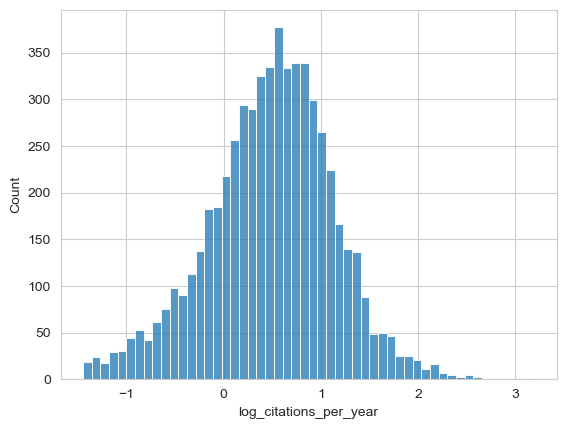

In [43]:
sns.histplot(
    df_train,
    x = 'log_citations_per_year',
)

## Numerical variables

(0.0, 40.0)

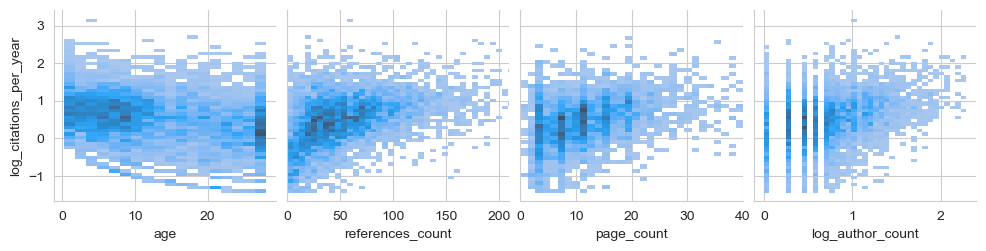

In [44]:
pairplot = sns.pairplot(
    df_train,
    x_vars = pm['numerical_variables'],
    y_vars = [ 'log_citations_per_year',],
    kind = 'hist',
    # plot_kws = { 'line_kws': { 'color': 'k', }, },
)
pairplot.axes[0,1].set_xlim( 0, 210 )
pairplot.axes[0,2].set_xlim( 0, 40 )

## Categorical variable

<AxesSubplot: xlabel='journal_filtered', ylabel='log_citations_per_year'>

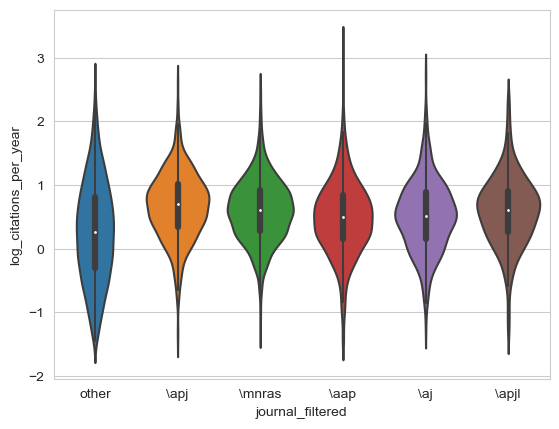

In [45]:
sns.violinplot(
    df_train,
    x = 'journal_filtered',
    y = 'log_citations_per_year',
)

# Modeling <a class="anchor" id="modeling"></a>

## Preprocessing <a class="anchor" id="preprocessing"></a>

In this section I set up pipelines to prepare the data for the ML models.

[**Back to Page Top**](#page-top)

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate, KFold

In [47]:
# Two things for our numerical variables:
# Imputation of missing values and scaling by mean and std
numerical_preprocessing = Pipeline(
    [
        ( 'impute', SimpleImputer( strategy='mean' ) ),
        ( 'scale', StandardScaler() ),
    ]
)

In [48]:
# Preprocessing for word vectors is just scaling
vector_preprocessing = Pipeline(
    [
        ( 'scale', Normalizer() ),
    ]
)

In [49]:
# There is a subset of the numerical variables that I refer to as "semantic".
# These variables contain metrics that measure the relationship of the words in a publication to words in other publications.
semantic_preprocessing = Pipeline(
    [
        ( 'scale', StandardScaler() ),
    ]
)

In [50]:
# Combine the numerical preprocessing with onehot encoding for the categorical variable
metadata_preprocessing = ColumnTransformer( [
        ( 'numerical', numerical_preprocessing, pm['numerical_variables'] ),
        ( 'onehot', OneHotEncoder(), pm['categorical_variables'] ),
] )

In [51]:
# For semantic and metadata combined
derived_preprocessing = ColumnTransformer( [
        ( 'numerical', numerical_preprocessing, pm['numerical_variables'] + pm['semantic_variables'] ),
        ( 'onehot', OneHotEncoder(), pm['categorical_variables'] ),
] )

In [52]:
# Set up a kfold object for cross validation
kfold = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 1532
)

In [53]:
# Object for storing data
crossvals = {}

## A Baseline Model <a class="anchor" id="baseline"></a>

I use the mean log citations per year as the baseline.

In [54]:
from sklearn.base import BaseEstimator

In [55]:
class Baseline( BaseEstimator ):
    '''The baseline model is just the mean. We put it into a class
    for full consistency with all future models.'''
    
    def fit( self, X , y):
        
        self.estimate = y.mean()
        
    def predict( self, X ):
        
        return np.full( X.shape[0], self.estimate )

model = Baseline()

In [56]:
model

Baseline()

In [57]:
# Perform and store cross validation
crossvals['baseline'] = verdict.Dict( cross_validate(
    estimator = model,
    X = X_train_df.values,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

Because the baseline is the mean the RMSE for the individual folds should be similar to the standard deviation of the full sample.

In [58]:
-crossvals['baseline']['test_score']

array([0.64482796, 0.66680128, 0.66007965, 0.63059422, 0.63430133])

In [59]:
sample_mean = y_train.mean()
sample_std = y_train.std()
sample_std

0.6472643986056894

## A Naive Model: Simple Linear Regression <a class="anchor" id="SLR"></a>

For the first model I'll see if we can just use linear least squares regression with the word vectors as input.
This is a pretty silly model: I'm limited to linear order because of the high dimensionality of the word vectors, and it is unlikely that a single line can describe the citation relationship.

[**Back to Page Top**](#page-top)

In [60]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [61]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [62]:
model

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scale', Normalizer())])),
                ('poly', PolynomialFeatures(degree=1)),
                ('reg', LinearRegression(fit_intercept=False))])

In [63]:
# Perform and store cross validation
crossvals['linear_regression'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [64]:
import matplotlib
import matplotlib.pyplot as plt

In [65]:
def rmse_swarmplot( crossval, y_lim=(sample_std-0.15, sample_std+0.15), ax=None ):    
    '''I'll use this plot throughout for showing results.'''
    
    # Format data
    df_data = -1. * verdict.Dict( crossvals ).inner_item( 'test_score' )
    crossval_df = pd.DataFrame( df_data._storage ).melt( var_name='model', value_name='rmse' )
    
    # Visualize
    if ax is None:
        fig = plt.figure( figsize=(len(df_data)*1.5, 3) )
        ax = plt.gca()
    
    # Plot itself
    sns.swarmplot(
        data = crossval_df,
        x = 'model',
        y = 'rmse',
        hue = 'model',
        ax = ax,
        legend = None,
    )
    
    # Mark the analytic baseline value for comparison
    ax.axhline(
        sample_std,
        color = '0.5',
        linestyle = '--',
        linewidth = 0.75,
    )

    ax.set_xlabel( 'model' )
    ax.set_ylabel( r'RMSE in $\log_{10}$( citations / year )' )
    
    ax.set_ylim( y_lim )
    
    return ax.get_figure()

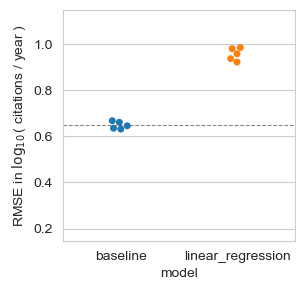

In [66]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.5, sample_std+0.5) )

No surprise, this model doesn't perform particularly well.

## A Basic Phenomenological Model: Random Forest <a class="anchor" id="random-forest"></a>

For a more-sophisticated phenomenological description of the data, I will try a random forest.

[**Back to Page Top**](#page-top)

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', RandomForestRegressor( max_depth=3, n_estimators=200 ) ),    ]
)

In [69]:
model

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scale', Normalizer())])),
                ('reg', RandomForestRegressor(max_depth=3, n_estimators=200))])

In [70]:
# Perform and store cross validation
crossvals['random_forest'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

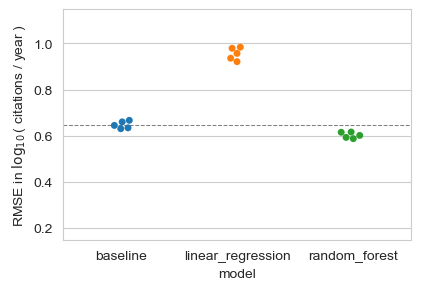

In [71]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.5, sample_std+0.5) )

Better performance than the baseline, at least!

## A Better Phenomoenological Model: Gradient Boosting <a class="anchor" id="grad-boosting"></a>

Since the random forest model went okay, how about a gradient boosting model with decision trees as the base?

[**Back to Page Top**](#page-top)

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

In [73]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [74]:
model

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scale', Normalizer())])),
                ('reg', GradientBoostingRegressor())])

In [75]:
# Perform and store cross validation
crossvals['grad_boost'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

In [76]:
# Let's go ahead and drop the linear regression model so it's not distracting us.
del crossvals['linear_regression']

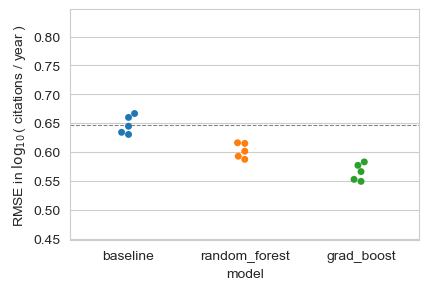

In [77]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.2, sample_std+0.2) )

In [78]:
print( 'We can predict the number of citations to within a factor of ~{:.2g} on average.'.format( 10.**-crossvals['grad_boost']['test_score'].mean() ) )

We can predict the number of citations to within a factor of ~3.7 on average.


There is still a significant amount of error in the prediction: a factor of a few in predicting the number of citations per year. This is perhaps to be expected: it would be surprising if the main thing driving citation trends could be predicted simply via the words used, with no information about how those words relate to one another (e.g. I'm not even using an N-gram language model).

## An Informed Model: K Nearest Neighbors <a class="anchor" id="KNN"></a>

So far I have been treating the word vectors as generic data. To further improve the modelling, and add some explanatory power, I will make use of our knowledge about what the vectors _are_: the language used in a scientific abstract.

Here's a simple hypothesis:
The number of citations a paper receives correlates with the number of citations papers on similar topics (i.e. using similar words) receive. Fortunately this is a simple, well-defined model: the K Nearest Neighbors model.

[**Back to Page Top**](#page-top)

In [79]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [80]:
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'knn', KNeighborsRegressor( n_neighbors=32 ) ),
    ]
)

In [81]:
model

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scale', Normalizer())])),
                ('knn', KNeighborsRegressor(n_neighbors=32))])

In [82]:
# Perform a parameter search for the number of neighbors to use
param_grid = {
    'knn__n_neighbors': [ 4, 16, 32, 64, 128, 256, ],
}
search = GridSearchCV( model, param_grid, )
search.fit( v_train, df_train['log_citations_per_year'] )
model = search.best_estimator_
search.best_params_

{'knn__n_neighbors': 16}

In [83]:
# Perform and store cross validation
crossvals['KNN'] = verdict.Dict( cross_validate(
    estimator = model,
    X = v_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

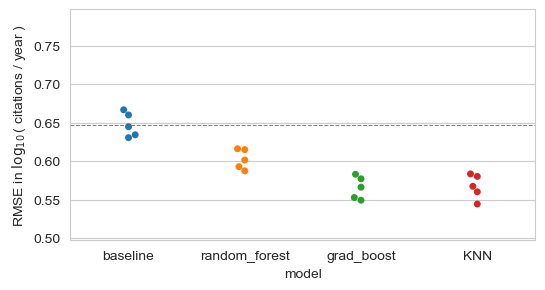

In [84]:
fig = rmse_swarmplot( crossvals )

KNN does comparably well to gradient boosting, but is much more interpretable!

## Another Informed Model: Density and Asymmetry <a class="anchor" id="explanatory"></a>

Related to K Nearest Neighbors, we can ask if the local geometry of the hyperspace is related to citations received. In particular, I will use two metrics I have previously calculated and will be presenting in an upcoming paper (Imel & Hafen in prep):

density, which tracks the number of similar papers,
$${\rm density} = \frac{K}{{\rm distance\,to\,the\,farthest\,neighbor}}$$

and asymmetry, which tracks if a paper uses language in a new direction relative to existing similar papers.
$${\rm fringe\,factor} = \frac1K \sum_{i=1}^{K} \frac{\vec v - \vec v_i}{|\vec v - \vec v_i|} $$
The asymmetry metric is inspired by force balance.

These metrics consist of only two quantities most of the meaningful modeling is in the calculation of these two quantities, so I'll fit a simple linear regression.

[**Back to Page Top**](#page-top)

<AxesSubplot: xlabel='density', ylabel='Count'>

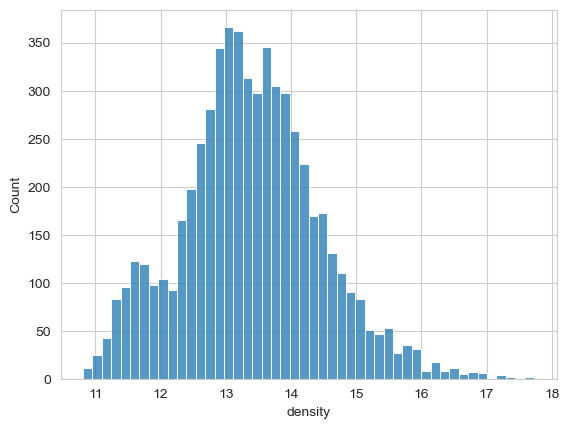

In [85]:
sns.histplot(
    df_train,
    x = 'density',
)

<AxesSubplot: xlabel='asymmetry', ylabel='Count'>

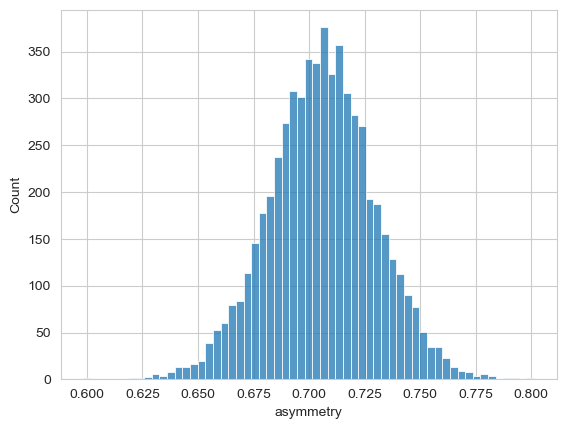

In [86]:
sns.histplot(
    df_train,
    x = 'asymmetry',
)

In [87]:
semantic_model = Pipeline(
    [
        ( 'preprocessing', semantic_preprocessing ),
        ( 'poly', PolynomialFeatures( degree=1 ) ),
        ( 'reg', LinearRegression( fit_intercept=False ) ),
    ]
)

In [88]:
semantic_model

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scale', StandardScaler())])),
                ('poly', PolynomialFeatures(degree=1)),
                ('reg', LinearRegression(fit_intercept=False))])

In [89]:
# Perform and store cross validation
crossvals['semantic_features'] = verdict.Dict( cross_validate(
    estimator = semantic_model,
    X = M_train,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

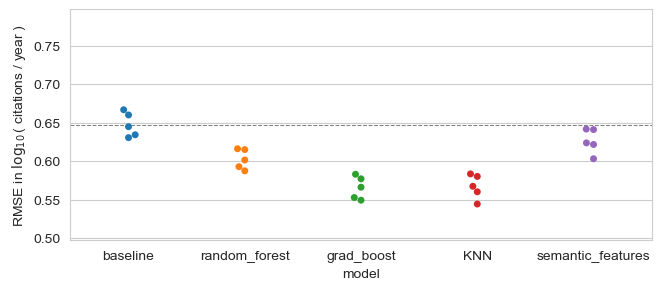

In [90]:
fig = rmse_swarmplot( crossvals )

Regressing on the explanatory variables of density and fringe factor does not produce the best model, but nevertheless holds some predictive power.

## A Model Utilizing Metadata <a class="anchor" id="metadata"></a>

Until now I used only the word content of the abstract. But presumably the number of citations received is a function of much more than the words employed. I have gathered a number of additional attributes for each publication, and we will regress onto those too.

[**Back to Page Top**](#page-top)

In [91]:
X_train_df.sample( 5 )

,age,references_count,page_count,log_author_count,journal_filtered
2004MNRAS.355..591I,18.469477,28,9.0,0.602060,\mnras
2011arXiv1101.2362Z,12.355184,9,NaN,0.301030,other
2021FrP.....9..709P,0.315615,188,NaN,0.000000,other
2005ApJ...628..160C,17.822983,53,8.0,0.778151,\apj
2000MNRAS.318..938M,22.548411,24,4.0,0.301030,\mnras


I will regress with gradient boosting, but in exploratory modeling I discovered that most other reasonable ML models perform similarly.

In [92]:
metadata_model = Pipeline(
    [
        ( 'preprocessing', metadata_preprocessing ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [93]:
metadata_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'references_count',
                                                   'page_count',
                                                   'log_author_count']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['journal_filtered'])])),
                ('reg', GradientBoostingRegressor())])

In [94]:
# Perform and store cross validation
crossvals['metadata'] = verdict.Dict( cross_validate(
    estimator = metadata_model,
    X = X_train_df,
    y = y_train,
    cv = kfold,
    scoring = 'neg_root_mean_squared_error',
    return_estimator = True,
) )

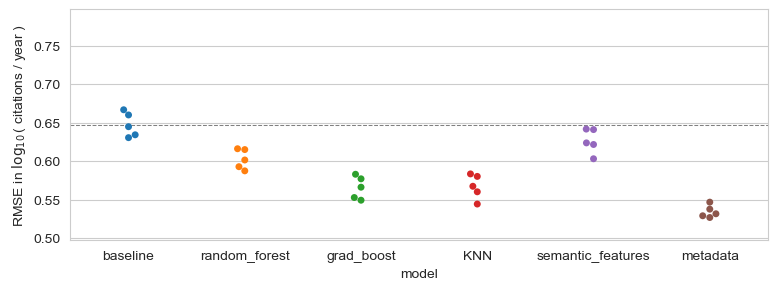

In [95]:
fig = rmse_swarmplot( crossvals )

The metadata contains a lot of information useful for predicting citations!

## A Neural Net <a class="anchor" id="neural-net"></a>

I will wrap up the individual modeling with a simple neural net regressed onto the word vectors.

[**Back to Page Top**](#page-top)

In [96]:
import keras

2023-06-24 18:25:09.341785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
from sklearn.metrics import mean_squared_error

In [98]:
# Simple multilayer model
class NeuralNet( BaseEstimator ):
    '''The estimator for the neural net.
    We need to wrap it as such because the output of the keras predict function
    is not what the voting regressor expects.
    Also, the voting regressor expects estimator._estimator_type = 'regressor'.
    '''
    
    def __init__( self ):

        # Build the model itself
        neural_net = keras.models.Sequential()
        neural_net.add( keras.layers.Input( shape=(v.shape[1],) ) )
        neural_net.add( keras.layers.Dense( 16, activation='relu', ) )
        neural_net.add( keras.layers.Dense( 16, activation='relu', ) )
        neural_net.add( keras.layers.Dense( 16, activation='relu', ) )
        neural_net.add( keras.layers.Dense( 1, ) )
        neural_net.compile( loss='mean_squared_error' )
        
        self.neural_net = neural_net
        self._estimator_type = 'regressor'
    
    def fit( self, X, y, *args, **kwargs ):
        
        self.neural_net.fit( X, y, *args, **kwargs )
    
    def predict( self, X, *args, **kwargs ):
        
        raw_result = self.neural_net.predict( X, *args, **kwargs )
        
        return raw_result.transpose()[0]

In [99]:
# Actually build the model
model = Pipeline(
    [
        ( 'preprocessing', vector_preprocessing ),
        ( 'reg', NeuralNet() ),
    ]
)

In [100]:
model

Pipeline(steps=[('preprocessing', Pipeline(steps=[('scale', Normalizer())])),
                ('reg', NeuralNet())])

In [101]:
# Perform KFold cross validation
# We could use the exact same code as before, but this allows a little additional control.
crossvals['neural_net'] = {'test_score':[], 'estimator':[],}
for train_index, test_index in kfold.split(v_train):
        
    # Fit and predict
    model.fit( v_train[train_index].toarray(), y_train[train_index] )
    log_cpy_pred = model.predict( v_train[test_index].toarray() )
    
    # Compare prediction
    rmse = -np.sqrt( mean_squared_error( y_train[test_index], log_cpy_pred ) )
    crossvals['neural_net']['test_score'].append( rmse )
    crossvals['neural_net']['estimator'].append( model )
crossvals['neural_net']['test_score'] = np.array( crossvals['neural_net']['test_score'] )

37/37 [==============================] - 0s 1ms/step


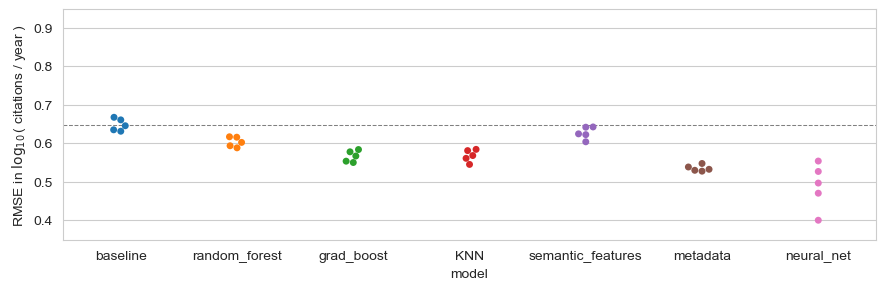

In [102]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.3, sample_std+0.3 ) )

While arguably the biggest blackbox of the considered models, the simple neural net performs remarkably well for predicting citations given the words used, at least on the training set.

## Putting it All Together: Voting Regression <a class="anchor" id="voting"></a>

I'll now try to combine the models to offset their weaknesses.

Metadata and semantic features will be combined into one dataset, and modeled with gradient boosting.

For word vectors I will use the best of the intuitive models (the K Nearest Neighbors model) and the best of all the word vector models (the neural net).

[**Back to Page Top**](#page-top)

In [103]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingRegressor

In [104]:
# Combine word vectors, semantic variables, and metadata into a single feature array
D_train = derived_preprocessing.fit_transform( D_train_df )
n_sample = D_train.shape[0]
n_D = D_train.shape[1]
n_v = v_train.shape[1]
A_train = np.zeros( shape=(n_sample, n_D + n_v) )
A_train[:,:n_D] = D_train
A_train[:,n_D:] = vector_preprocessing.fit_transform( v_train ).toarray()

In [105]:
# Build preprocessing objects to select either only the word vectors or the other features
select_word_vectors = FunctionTransformer( lambda A: A[:,n_D:] )
select_derived_features = FunctionTransformer( lambda A: A[:,:n_D] )

In [106]:
# Gradient boost for all the derived features (metadata and semantic)
derived_features_grad_boosting = Pipeline(
    [
        ( 'select_derived_features', select_derived_features ),
        ( 'reg', GradientBoostingRegressor() ),
    ]
)

In [107]:
# The most-successful intuitive word vector model
vector_knn = Pipeline(
    [
        ( 'select_word_vectors', select_word_vectors ),
        ( 'reg', KNeighborsRegressor( n_neighbors=search.best_params_['knn__n_neighbors'] ) ),
    ]
)

In [108]:
# The neural net    
vector_neural_net = Pipeline(
    [
        ( 'select_word_vectors', select_word_vectors ),
        ( 'reg', NeuralNet() ),
    ]
) 

In [109]:
# Put it together!
model = VotingRegressor(
    estimators = [
        ( 'vector_knn', vector_knn ),
        ( 'derived_features_grad_boosting', derived_features_grad_boosting ),
        ( 'vector_neural_net', vector_neural_net ),
    ],
)

In [110]:
model

VotingRegressor(estimators=[('vector_knn',
                             Pipeline(steps=[('select_word_vectors',
                                              FunctionTransformer(func=<function <lambda> at 0x7fabccffd6c0>)),
                                             ('reg',
                                              KNeighborsRegressor(n_neighbors=16))])),
                            ('derived_features_grad_boosting',
                             Pipeline(steps=[('select_derived_features',
                                              FunctionTransformer(func=<function <lambda> at 0x7fabccffd7e0>)),
                                             ('reg',
                                              GradientBoostingRegressor())])),
                            ('vector_neural_net',
                             Pipeline(steps=[('select_word_vectors',
                                              FunctionTransformer(func=<function <lambda> at 0x7fabccffd6c0>)),
                                             ('reg', NeuralNet())]))])

In [111]:
# Perform KFold cross validation
crossvals['voting'] = {'test_score':[], 'estimator':[],}
for train_index, test_index in kfold.split(A_train):
        
    # Fit and predict
    model.fit( A_train[train_index], y_train[train_index] )
    log_cpy_pred = model.predict( A_train[test_index] )
    
    # Compare prediction
    rmse = -np.sqrt( mean_squared_error( y_train[test_index], log_cpy_pred ) )
    crossvals['voting']['test_score'].append( rmse )
    crossvals['voting']['estimator'].append( model )
crossvals['voting']['test_score'] = np.array( crossvals['voting']['test_score'] )

37/37 [==============================] - 0s 1ms/step


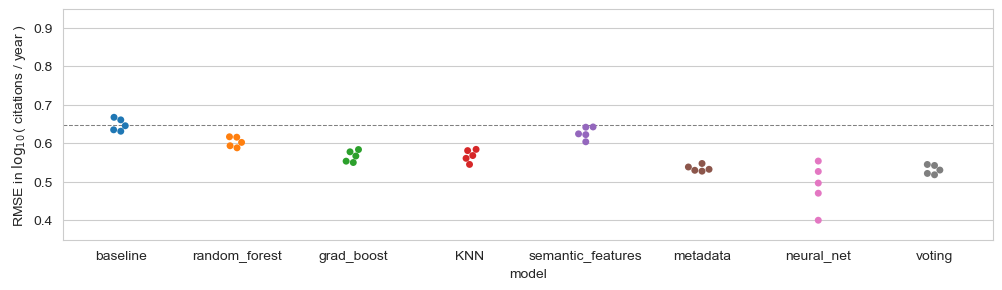

In [112]:
fig = rmse_swarmplot( crossvals, y_lim=(sample_std-0.3, sample_std+0.3 ) )

The performance of the voting model is comparable to that of the metadata model.

## Final Validation <a class="anchor" id="validation"></a>
Time to check how the models do on the validation dataset!

[**Back to Page Top**](#page-top)

In [113]:
# Combine word vectors, semantic variables, and metadata into a single feature array
D_test = derived_preprocessing.fit_transform( D_test_df )
n_sample = D_test.shape[0]
n_D = D_test.shape[1]
n_v = v_test.shape[1]
A_test = np.zeros( shape=(n_sample, n_D + n_v) )
A_test[:,:n_D] = D_test
A_test[:,n_D:] = vector_preprocessing.fit_transform( v_test ).toarray()

In [114]:
# Fit to all training, and test!
ys = {
    'actual': y_test,
}
rmses = {}
for model_name, item in tqdm.tqdm( crossvals.items() ):
    
    # Retrieve the model
    model = item['estimator'][0]
    
    # Fit and predict
    if model_name in [ 'baseline', 'random_forest', 'grad_boost', 'KNN', 'neural_net' ]:
        model.fit( v_train, y_train )
        y_pred = model.predict( v_test )
    elif model_name == 'semantic_features':
        model.fit( M_train, y_train )
        y_pred = model.predict( M_test )
    elif model_name == 'metadata':
        model.fit( X_train_df, y_train )
        y_pred = model.predict( X_test_df )
    elif model_name == 'voting':
        model.fit( A_train, y_train )
        y_pred = model.predict( A_test )
    else:
        raise KeyError( 'Unknown model name, {}'.format( model_name ) )
        
    ys[model_name] = y_pred
    rmses[model_name] = np.sqrt( mean_squared_error( y_test, y_pred ) )

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6/8 [00:48<00:11,  5.68s/it]2023-06-24 18:26:51.456646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5887]
	 [[{{node Placeholder/_1}}]]
2023-06-24 18:26:51.456891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [5887]
	 [[{{node Placeholder/_1}}]]


46/46 [==============================] - 0s 745us/step


2023-06-24 18:26:52.112521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [1472,3]
	 [[{{node Placeholder/_0}}]]
 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7/8 [00:49<00:04,  4.38s/it]

46/46 [==============================] - 0s 1ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:57<00:00,  7.13s/it]


In [115]:
# Calculate what fraction of estimates we get correct.
# I will print this later.
cpy_df = pd.DataFrame( ys ).apply( lambda x: 10.**x )
cpy_diff = np.abs( cpy_df['actual'] - cpy_df['voting'] )
dist, bins = np.histogram(
    cpy_diff,
    bins = np.arange( 0, cpy_diff.max()+1, 1 ),
)
cdist = np.cumsum( dist )
pdist = cdist / cdist[-1] * 100

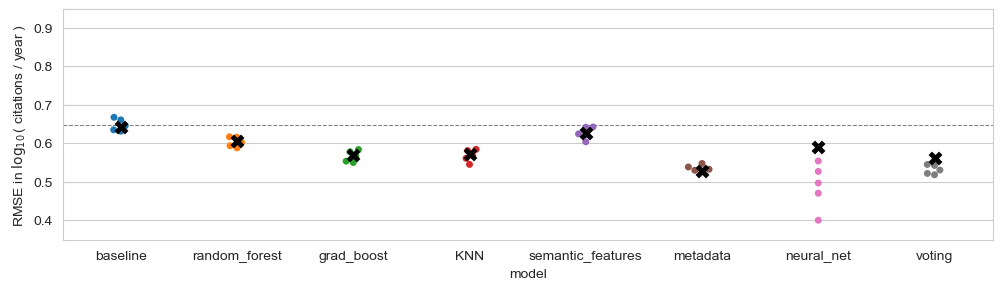

In [116]:
fig = plt.figure( figsize=(len(rmses)*1.5, 3) )
ax = plt.gca()

rmse_df = pd.DataFrame({
    'model_name': list( rmses.keys() ),
    'rmse': list( rmses.values() ),
})

sns.swarmplot(
    rmse_df,
    y = 'rmse',
    x = 'model_name',
    color = 'k',
    marker = 'X',
    s = 10,
    edgecolor = 'k',
    ax = ax,
    legend = None,
    zorder = 10,
)

fig = rmse_swarmplot( crossvals, ax=ax, y_lim=( sample_std-0.3, sample_std+0.3) )

Black "x"s indicate the RMSE for the validation sample.

The neural net does significantly worse for the validation sample, suggesting it is overfit. On the other hand, voting, which includes the neural net, does just as well as before.

# Takeaways <a class="anchor" id="takeaways"></a>

I predicted the number of citations a publication will receive per year, using as input:
* the full word content of the abstract
* metrics relating the word content of the abstract to other papers in the sample
* publication metadata:
  * what year the paper is published
  * how many references are in the paper
  * how long the paper is
  * how many authors the paper has
  * the journal the paper is published in

In [117]:
print( (
    'The best model can predict the number of citations per year to within a factor of ~{:.2g},\n'.format( 10.**rmse_df['rmse'].min() ) +
    'compared to a factor of ~{:.2g} for the baseline.'.format( 10.**rmses['baseline'] )
) )


The best model can predict the number of citations per year to within a factor of ~3.4,
compared to a factor of ~4.4 for the baseline.


In [118]:
print( (
    'The best model estimates the citation count to within {:.2g} citations per year for {:.2g}% of publications.'.format( bins[3], pdist[3] )
) )

The best model estimates the citation count to within 3 citations per year for 76% of publications.


[**Back to Page Top**](#page-top)

# Cautions

* **The predicted citation count is not a measure of paper quality.** In fact, quality may correlate with how much the predicted citation count *disagrees* with the actual value&mdash;receiving an exceptionally large (or small) number of citations given the number of authors, age, journal, topic, etc. may occur if the paper is especially valuable (or not).

* **Addressing the time-dependence must be done before using the models for serious applications.** Citations received is time-dependent, e.g. a publication cannot be cited by pre-existing publications. This analysis does not take this into account with the exception of density and asymmetry, which are calculated using only pre-existing publications.

* **These models are trained on log citations per year** because the citation distribution is known to be log-normal. Related, it is not surprising that the models estimate the citation count to within only a few citations per year, because most papers receive only a few citations per year. 

* Additional exploratory analysis and modeling was done separately, and is available upon request.

# Credits

Python packages essential to this analysis include:

* [cc](https://github.com/zhafen/cc) (my package for NLP of scientific abstracts)
* [scikit-learn](https://scikit-learn.org/stable/index.html)
* [TensorFLow](https://doi.org/10.5281/zenodo.4724125)
* [pandas](https://pandas.pydata.org/)
* [ads](https://github.com/andycasey/ads)
* [nltk](https://www.nltk.org/)
* [numpy](https://doi.org/10.1038/s41586-020-2649-2)
* [matplotlib](https://doi.org/10.5281/zenodo.592536)
* [seaborn](https://seaborn.pydata.org/index.html)